## CMPINF - 2100 - Final Project - Cross-Validation

## Khan, Rifat 

## Import Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

import statsmodels.formula.api as smf




## Read data 

Load data into notebook

In [2]:
songs_url = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv'

In [3]:
df = pd.read_csv(songs_url)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  
 14  loudne

In [5]:
df_copy = df.copy()

In [6]:
df_copy.drop(df_copy[df_copy['speechiness'] == 0].index, inplace=True)
df_copy.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [7]:
df_copy['energy'] = np.power(df_copy.energy, 2)
df_copy['acousticness'] = np.power(df_copy.acousticness, 1/4) 
df_copy['liveness'] = np.log(df_copy.liveness) 
df_copy['speechiness'] = np.log(df_copy.speechiness) 

In [8]:
df_copy['mode'] = df_copy['mode'].astype('object')
df_copy['key'] = df_copy['key'].astype('object')

In [9]:
popularity_threshold = df_copy.track_popularity.median()
df_copy['popularity_label'] = np.where(df_copy['track_popularity'] >= popularity_threshold, 1, 0)

In [10]:
df_copy.popularity_label.value_counts(normalize=True)

popularity_label
1    0.51331
0    0.48669
Name: proportion, dtype: float64

In [11]:
df_modelling = df_copy.groupby(['track_id'], dropna=False).\
aggregate(playlist_genre = ('playlist_genre', 'first'),
          danceability = ('danceability', 'mean'),
          energy = ('energy', 'mean'),
          key = ('key', 'first'),
          mode = ('mode', 'first'),
          acousticness = ('acousticness', 'mean'),
          liveness= ('liveness', 'mean'),
          valence = ('valence', 'mean'),
          duration_ms = ('duration_ms', 'mean'),
          y = ('popularity_label', 'first')).\
reset_index()


In [12]:
formula_list = ['y ~ 1', # Intercept only
                'y ~ key + mode + playlist_genre', # Categorical additive
                'y ~ danceability + energy + acousticness + liveness + valence + duration_ms', # Continous additive 
                'y ~ key + mode + playlist_genre + danceability + energy + acousticness + liveness + valence + duration_ms', #All inputs with linear additive features
                'y ~ (danceability + energy + acousticness + liveness + valence + duration_ms)**2',# Continous inputs with linear main effect and pair-wise interactions
                'y ~ (key + mode + playlist_genre)*(danceability + energy + acousticness + liveness + valence + duration_ms)', #Interactive categorical and continous
                'y ~ (key+ mode) + (energy + acousticness)', #Model choice 1
                'y ~ playlist_genre * (danceability + valence)'] #Model choice 2

## Cross-Validation

First let us set up the k-fold generators for cross validations

### K-fold generators

In [13]:
kf = StratifiedKFold( n_splits= 5, shuffle=True, random_state= 101)

In [14]:
kf.get_n_splits()

5

In [15]:
input_names = df_modelling.drop(columns=['y']).copy().columns.to_list()
input_names

['track_id',
 'playlist_genre',
 'danceability',
 'energy',
 'key',
 'mode',
 'acousticness',
 'liveness',
 'valence',
 'duration_ms']

In [16]:
output_name = 'y'

Also need to create data set that needs to be standardized

In [17]:
log_std = [ 'danceability',
            'energy',
            'acousticness',
            'liveness',
            'valence',
            'duration_ms']

Let's define a Function that manages the Fitting and PERFORMANCE METRIC calculation within the CROSS-Validation FOLDS!

Focus on the ACCURACY as our Performance metric!

In [18]:
def train_and_test_logistic_with_cv(mod_name, a_formula, data_df, x_names, y_name, std_vars, cv, threshold=0.5):
    # seperate the inputs and output 
    input_df = data_df.loc[ :, x_names ].copy()

    # Initialize the performance metric storage lists
    train_res = []
    test_res = [] 

    # SPLIT the data and iterate over the folds 
    for train_id, test_id in cv.split(input_df.to_numpy(), data_df[ y_name].to_numpy()):
        # subset the training and test splits within each fold
        train_data = data_df.iloc[ train_id, :].copy()
        test_data = data_df.iloc[ test_id, :].copy()

        # standardize
        train_data[std_vars] = StandardScaler().fit_transform(train_data[std_vars])
        test_data[std_vars] = StandardScaler().fit_transform(test_data[std_vars])
        
        # Fit the model on the TRAINING data within the current FOLD 
        a_mod = smf.logit( formula=a_formula , data=train_data).fit()

        # Predict the TRAINING within each FOLD
        train_copy = train_data.copy()
        train_copy['pred_probability'] = a_mod.predict( train_data )
        train_copy['pred_class'] = np.where( train_copy.pred_probability > threshold, 1, 0)

        # Predict the TESTING within each fold
        test_copy = test_data.copy()
        test_copy['pred_probability'] = a_mod.predict( test_data )
        test_copy['pred_class'] = np.where( test_copy.pred_probability > threshold, 1, 0)

        # Calculate the PERFORMANCE METRIC on the TRAINNG SET within the FOLD
        train_res.append( np.mean( train_copy[ y_name] == train_copy.pred_class))

        # Calculate the PERFORMANCE METRIC on the TESTING SET within the FOLD
        test_res.append( np.mean( test_copy[ y_name] == test_copy.pred_class))

   # bookeeping to store the results
    train_df = pd.DataFrame({'Accuracy': train_res})
    train_df['from_set'] = 'training'
    train_df['fold_id'] = train_df.index + 1

    test_df = pd.DataFrame({'Accuracy': test_res})
    test_df['from_set'] = 'testing'
    test_df['fold_id'] = test_df.index + 1

    # combine the splits together
    res_df = pd.concat([train_df, test_df], ignore_index=True)

    # add information about the model
    res_df['model_name'] = mod_name
    res_df['model_formula'] = a_formula
    res_df['num_coeffs'] = len(a_mod.params)
    res_df['threshold'] = threshold

    return res_df

In [19]:
cv_res_mod_6 = train_and_test_logistic_with_cv(6, formula_list[6-1], data_df=df_modelling, x_names= input_names, y_name= output_name, std_vars=log_std, cv=kf)

Optimization terminated successfully.
         Current function value: 0.652897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.654470
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.653409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.652852
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.654316
         Iterations 6


In [20]:
cv_res_mod_6

,Accuracy,from_set,fold_id,model_name,model_formula,num_coeffs,threshold
0,0.607433,training,1,6,y ~ (key + mode + playlist_genre)*(danceabilit...,126,0.5
1,0.602583,training,2,6,y ~ (key + mode + playlist_genre)*(danceabilit...,126,0.5
2,0.606771,training,3,6,y ~ (key + mode + playlist_genre)*(danceabilit...,126,0.5
3,0.606859,training,4,6,y ~ (key + mode + playlist_genre)*(danceabilit...,126,0.5
4,0.605890,training,5,6,y ~ (key + mode + playlist_genre)*(danceabilit...,126,0.5
5,0.592664,testing,1,6,y ~ (key + mode + playlist_genre)*(danceabilit...,126,0.5
6,0.611356,testing,2,6,y ~ (key + mode + playlist_genre)*(danceabilit...,126,0.5
7,0.588785,testing,3,6,y ~ (key + mode + playlist_genre)*(danceabilit...,126,0.5
8,0.591077,testing,4,6,y ~ (key + mode + playlist_genre)*(danceabilit...,126,0.5
9,0.600600,testing,5,6,y ~ (key + mode + playlist_genre)*(danceabilit...,126,0.5


In [21]:
cv_res_mod_8 = train_and_test_logistic_with_cv(8, formula_list[8-1], data_df=df_modelling, x_names= input_names, y_name= output_name, std_vars=log_std, cv=kf)

cv_res_mod_5 = train_and_test_logistic_with_cv(5, formula_list[5-1], data_df=df_modelling, x_names= input_names, y_name= output_name, std_vars=log_std, cv=kf)

Optimization terminated successfully.
         Current function value: 0.665954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.666552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.666776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.666128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.666637
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.672745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.674863
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.673903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.673270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.674654
  

In [22]:
cv_res_mod_8

,Accuracy,from_set,fold_id,model_name,model_formula,num_coeffs,threshold
0,0.581599,training,1,8,y ~ playlist_genre * (danceability + valence),18,0.5
1,0.581511,training,2,8,y ~ playlist_genre * (danceability + valence),18,0.5
2,0.583848,training,3,8,y ~ playlist_genre * (danceability + valence),18,0.5
3,0.581820,training,4,8,y ~ playlist_genre * (danceability + valence),18,0.5
4,0.582834,training,5,8,y ~ playlist_genre * (danceability + valence),18,0.5
5,0.579968,testing,1,8,y ~ playlist_genre * (danceability + valence),18,0.5
6,0.585964,testing,2,8,y ~ playlist_genre * (danceability + valence),18,0.5
7,0.573797,testing,3,8,y ~ playlist_genre * (danceability + valence),18,0.5
8,0.580321,testing,4,8,y ~ playlist_genre * (danceability + valence),18,0.5
9,0.575560,testing,5,8,y ~ playlist_genre * (danceability + valence),18,0.5


In [23]:
cv_res_mod_5

,Accuracy,from_set,fold_id,model_name,model_formula,num_coeffs,threshold
0,0.569168,training,1,5,y ~ (danceability + energy + acousticness + li...,22,0.5
1,0.565112,training,2,5,y ~ (danceability + energy + acousticness + li...,22,0.5
2,0.569873,training,3,5,y ~ (danceability + energy + acousticness + li...,22,0.5
3,0.570446,training,4,5,y ~ (danceability + energy + acousticness + li...,22,0.5
4,0.566346,training,5,5,y ~ (danceability + energy + acousticness + li...,22,0.5
5,0.560219,testing,1,5,y ~ (danceability + energy + acousticness + li...,22,0.5
6,0.572033,testing,2,5,y ~ (danceability + energy + acousticness + li...,22,0.5
7,0.564803,testing,3,5,y ~ (danceability + energy + acousticness + li...,22,0.5
8,0.558279,testing,4,5,y ~ (danceability + energy + acousticness + li...,22,0.5
9,0.570799,testing,5,5,y ~ (danceability + energy + acousticness + li...,22,0.5


In [24]:
res_list = []
res_list.append(cv_res_mod_6)
res_list.append(cv_res_mod_8)
res_list.append(cv_res_mod_5)

In [25]:
cv_results = pd.concat(res_list, ignore_index=True) 

In [26]:
cv_results

,Accuracy,from_set,fold_id,model_name,model_formula,num_coeffs,threshold
0,0.607433,training,1,6,y ~ (key + mode + playlist_genre)*(danceabilit...,126,0.5
1,0.602583,training,2,6,y ~ (key + mode + playlist_genre)*(danceabilit...,126,0.5
2,0.606771,training,3,6,y ~ (key + mode + playlist_genre)*(danceabilit...,126,0.5
3,0.606859,training,4,6,y ~ (key + mode + playlist_genre)*(danceabilit...,126,0.5
4,0.605890,training,5,6,y ~ (key + mode + playlist_genre)*(danceabilit...,126,0.5
5,0.592664,testing,1,6,y ~ (key + mode + playlist_genre)*(danceabilit...,126,0.5
6,0.611356,testing,2,6,y ~ (key + mode + playlist_genre)*(danceabilit...,126,0.5
7,0.588785,testing,3,6,y ~ (key + mode + playlist_genre)*(danceabilit...,126,0.5
8,0.591077,testing,4,6,y ~ (key + mode + playlist_genre)*(danceabilit...,126,0.5
9,0.600600,testing,5,6,y ~ (key + mode + playlist_genre)*(danceabilit...,126,0.5


/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


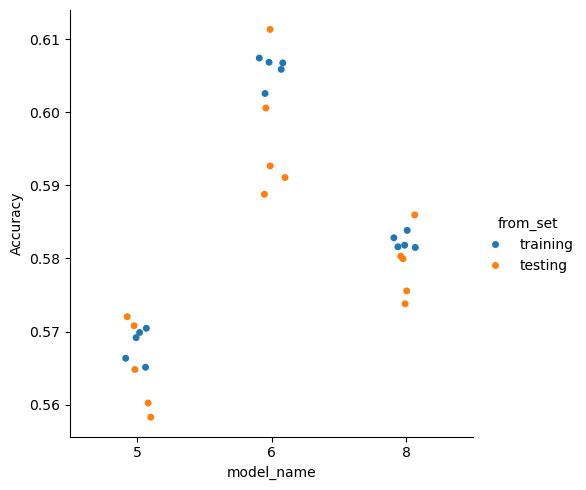

In [27]:
sns.catplot(data = cv_results, x='model_name', y='Accuracy', hue='from_set')

plt.show()

/var/folders/2c/j0kw_j7147b6qk3gzzl6cb100000gn/T/ipykernel_63392/396052923.py:3: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data = cv_results.loc[ cv_results.from_set == 'testing', :],
/var/folders/2c/j0kw_j7147b6qk3gzzl6cb100000gn/T/ipykernel_63392/396052923.py:6: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data = cv_results.loc[ cv_results.from_set == 'testing', :],


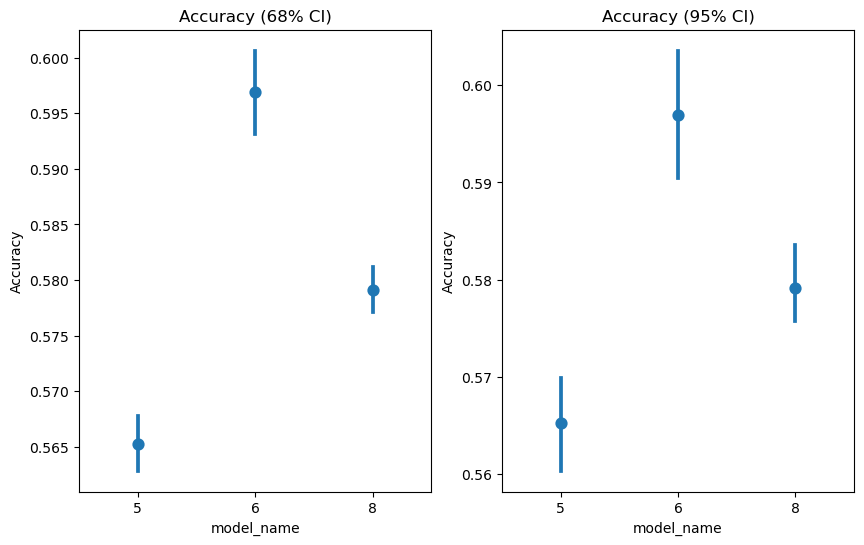

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))

sns.pointplot(data = cv_results.loc[ cv_results.from_set == 'testing', :],
            x='model_name', y='Accuracy', join=False,
            errorbar=('ci', 68), ax=ax[0])
sns.pointplot(data = cv_results.loc[ cv_results.from_set == 'testing', :],
            x='model_name', y='Accuracy', join=False,
            errorbar=('ci', 95), ax=ax[1])

ax[0].set_title('Accuracy (68% CI)')
ax[1].set_title('Accuracy (95% CI)')

plt.show()

/var/folders/2c/j0kw_j7147b6qk3gzzl6cb100000gn/T/ipykernel_63392/1355329558.py:4: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data = cv_results, x='model_name', y='Accuracy', hue='from_set', join=False, ax=ax)


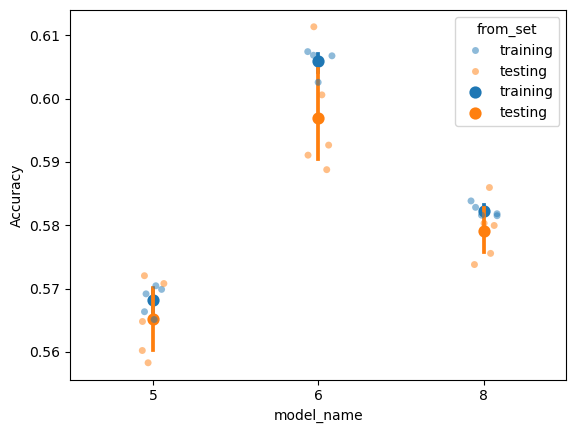

In [29]:
fig, ax = plt.subplots()

sns.stripplot(data = cv_results, x='model_name', y='Accuracy', hue='from_set', alpha=0.5, ax=ax)
sns.pointplot(data = cv_results, x='model_name', y='Accuracy', hue='from_set', join=False, ax=ax)

plt.show()

/var/folders/2c/j0kw_j7147b6qk3gzzl6cb100000gn/T/ipykernel_63392/3054396630.py:1: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.catplot(data = cv_results, x='model_name', y='Accuracy', hue='from_set', kind='point', join=False)
/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


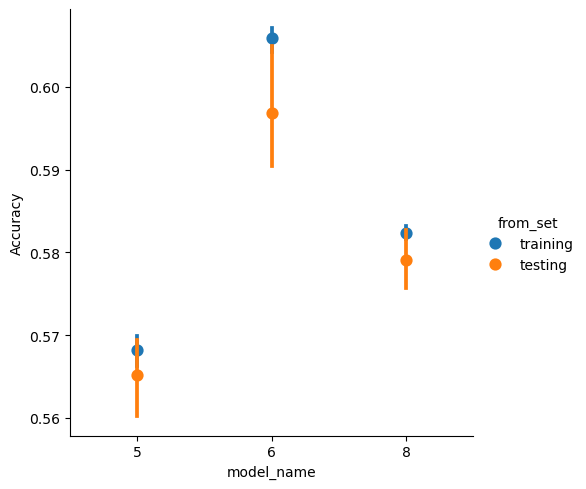

In [30]:
sns.catplot(data = cv_results, x='model_name', y='Accuracy', hue='from_set', kind='point', join=False)

plt.show()

In [31]:
results_list = [] 

for m in range( len(formula_list)):
    print( '-- Formula ID %d --' % m )

    try:
        results_list.append( train_and_test_logistic_with_cv(m+1, formula_list[m], data_df=df_modelling, x_names=input_names, y_name=output_name, std_vars=log_std, cv=kf))
    except:
        # what happens if there is an ERROR
        print( '-- Formula ID %d could NOT fit--' % m )

-- Formula ID 0 --
Optimization terminated successfully.
         Current function value: 0.690906
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690906
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690900
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690900
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690900
         Iterations 3
-- Formula ID 1 --
Optimization terminated successfully.
         Current function value: 0.669067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.669777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.669719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.669791
         Iterations 5
Optimization terminated successfully.
      

In [32]:
len( results_list )

8

In [33]:
len( formula_list )

8

In [34]:
cv_results = pd.concat( results_list, ignore_index=True)

In [35]:
cv_results

,Accuracy,from_set,fold_id,model_name,model_formula,num_coeffs,threshold
0,0.533460,training,1,1,y ~ 1,1,0.5
1,0.533460,training,2,1,y ~ 1,1,0.5
2,0.533504,training,3,1,y ~ 1,1,0.5
3,0.533504,training,4,1,y ~ 1,1,0.5
4,0.533504,training,5,1,y ~ 1,1,0.5
...,...,...,...,...,...,...,...
75,0.579968,testing,1,8,y ~ playlist_genre * (danceability + valence),18,0.5
76,0.585964,testing,2,8,y ~ playlist_genre * (danceability + valence),18,0.5
77,0.573797,testing,3,8,y ~ playlist_genre * (danceability + valence),18,0.5
78,0.580321,testing,4,8,y ~ playlist_genre * (danceability + valence),18,0.5


In [36]:
cv_results.model_name.value_counts()

model_name
1    10
2    10
3    10
4    10
5    10
6    10
7    10
8    10
Name: count, dtype: int64

/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


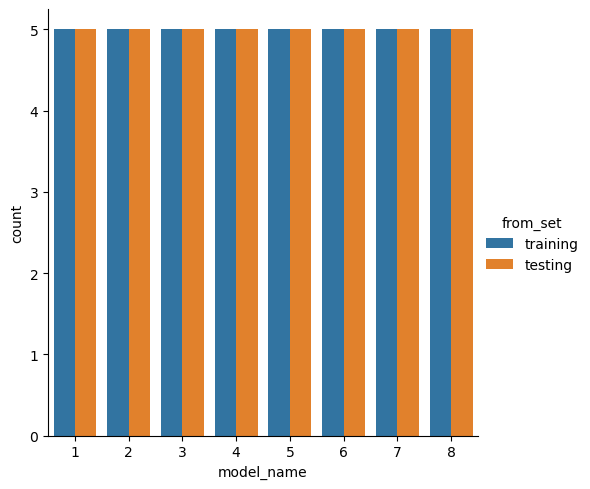

In [37]:
sns.catplot(data = cv_results, x='model_name', hue='from_set', kind='count')

plt.show()

/var/folders/2c/j0kw_j7147b6qk3gzzl6cb100000gn/T/ipykernel_63392/2894161676.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data = cv_results, x='model_name', y='Accuracy', hue='from_set', join=False, ax=ax)


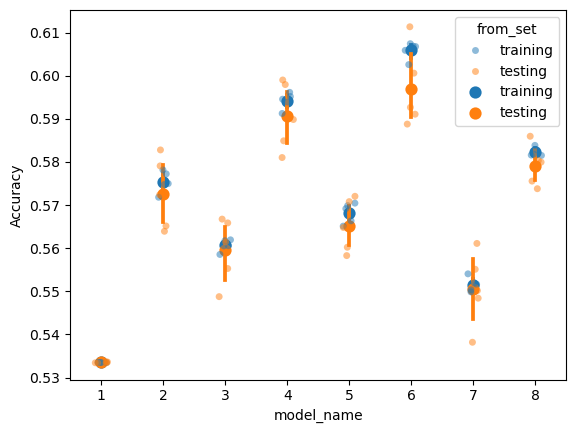

In [38]:
fig, ax = plt.subplots()

sns.stripplot(data = cv_results, x='model_name', y='Accuracy', hue='from_set', alpha=0.5, ax=ax)

sns.pointplot(data = cv_results, x='model_name', y='Accuracy', hue='from_set', join=False, ax=ax)

plt.show()

/var/folders/2c/j0kw_j7147b6qk3gzzl6cb100000gn/T/ipykernel_63392/954502244.py:1: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.catplot(data = cv_results.loc[ cv_results.from_set == 'testing', :],
/opt/anaconda3/envs/cmpinf2100/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


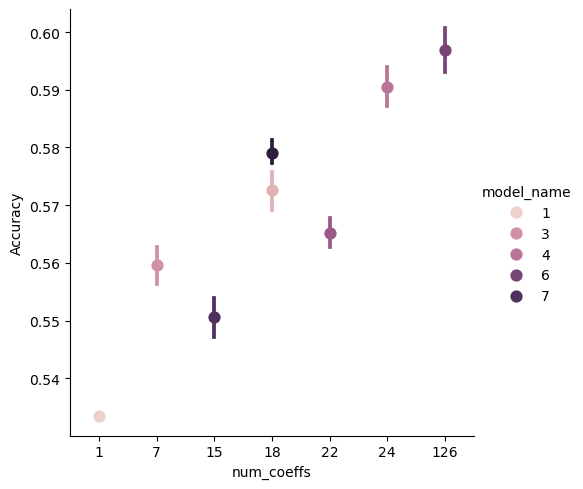

In [39]:
sns.catplot(data = cv_results.loc[ cv_results.from_set == 'testing', :], 
            x='num_coeffs', y='Accuracy', join=False, kind='point',
            hue='model_name',
            errorbar=('ci', 68))

plt.show()